## Decoding in sensor space data using the Common Spatial Pattern (CSP)

We plan on using a CSP mapping scheme to identify which channels are most useful in deciding new/scrambled images. 

The code for the brain mapping is from the MNE documentation: https://martinos.org/mne/stable/auto_examples/decoding/plot_decoding_csp_space.html



In [12]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams.update({'font.size': 12})


import mne 

path = "/Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run1-epo.fif"
epo_1 = mne.read_epochs(path, preload=True);


#extract only events with id 4 or 5 (new or scrambled)
epo_1 = epo_1[(epo_1.events[:,-1] == 4) | (epo_1.events[:,-1] == 5)]
epo_1 = epo_1.pick_channels(epo_1.ch_names[:60])

Reading /Users/shateeshbhugwansing/Desktop/seniorprojecteeg/clean_data_sample/Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [13]:
# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Romain Trachel <romain.trachel@inria.fr>
#
# License: BSD (3-clause)

tmin, tmax = 0.0, 1.4
labels = epo_1.events[:, -1]
evoked = epo_1.average()

In [14]:
#### Creating a linear SVM

from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa
from mne.decoding import CSP  # noqa

n_components = 4  # pick some components
svc = SVC(C=1, kernel='linear')
csp = CSP(n_components=n_components, norm_trace=False)

# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=15, test_size=0.2, random_state=42)
scores = []
predictions = []
epo_1_data = epo_1.get_data()

for train_idx, test_idx in cv.split(epo_1, labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epo_1_data[train_idx], y_train)
    X_test = csp.transform(epo_1_data[test_idx])

    # fit classifier
    svc.fit(X_train, y_train)
    scores.append(svc.score(X_test, y_test))

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))


Classification accuracy: 0.501149 / Chance level: 0.503546


In [15]:
predictions = svc.predict(X_test)
print(len(labels), len(predictions))
print(type(X_train))
print(len(X_test))

(141, 29)
<type 'numpy.ndarray'>
29


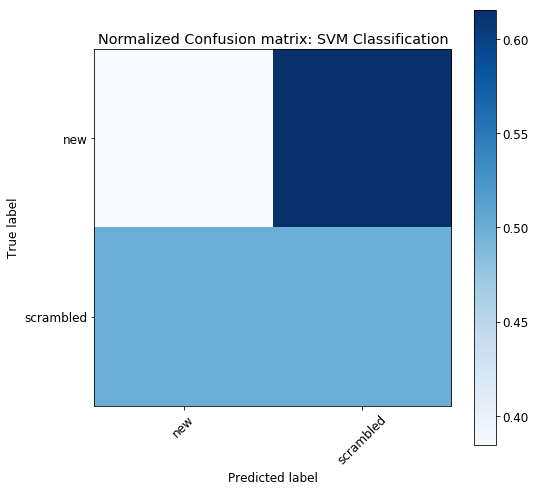

In [16]:
### visualize SVM model
from sklearn.metrics import classification_report, confusion_matrix

predictions = svc.predict(X_test)
target_names = ['new', 'scrambled']

# Normalized confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix: SVM Classification')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
# tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


<BarContainer object of 15 artists>

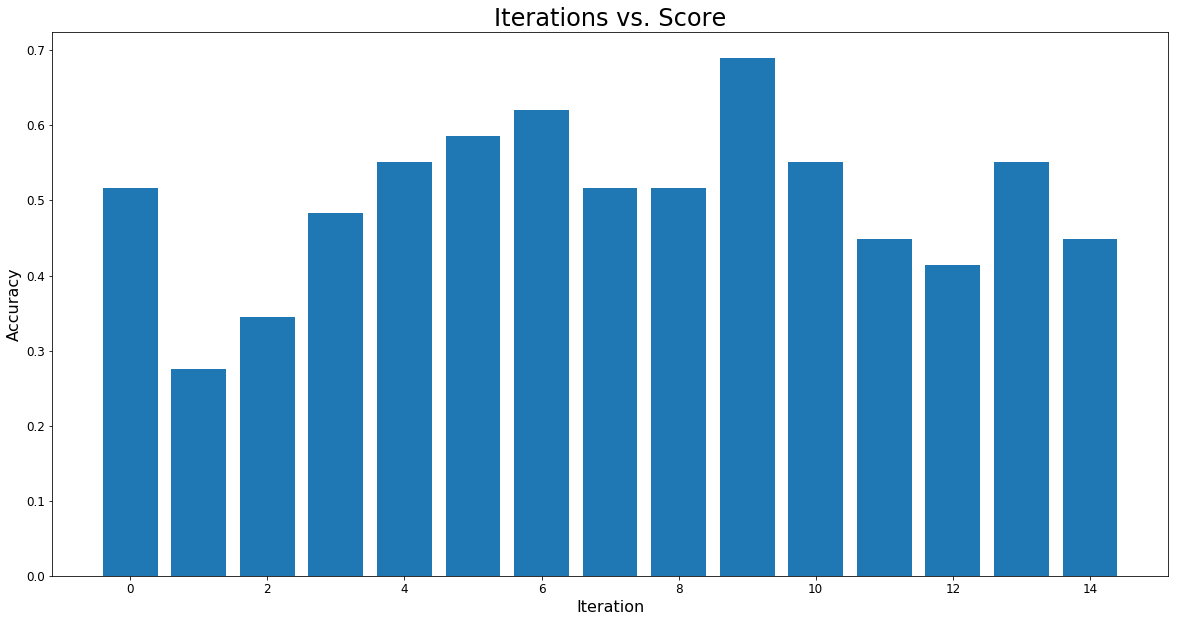

In [20]:
### Iteration vs. Score

plt.figure(figsize=(20, 10))
plt.title("Iterations vs. Score", fontsize=24)
plt.xlabel('Iteration',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.bar(range(len(scores)),scores)


In [ ]:

plt.title("Box & Whisker Plot of Scores")
plt.ylabel("Scores")
plt.boxplot(scores);

In [ ]:
# Or use much more convenient scikit-learn cross_val_score function using
# a Pipeline

from sklearn.pipeline import Pipeline  # noqa
from sklearn.model_selection import cross_val_score  # noqa

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, epo_1_data, labels, cv=cv, n_jobs=1)
print(scores.mean())  # should match results above

# And using reuglarized csp with Ledoit-Wolf estimator
csp = CSP(n_components=n_components, reg='ledoit_wolf', norm_trace=False)
clf = Pipeline([('CSP', csp), ('SVC', svc)])
scores = cross_val_score(clf, epo_1_data, labels, cv=cv, n_jobs=1)
print(scores.mean())  # should get better results than above
print(scores)
'''
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epo_1_data, labels)
data = csp.patterns_
fig, axes = plt.subplots(1, 4)
for idx in range(4):
    mne.viz.plot_topomap(data[idx], evoked.info, axes=axes[idx], show=False)
fig.suptitle('CSP patterns')
fig.tight_layout()
'''

In [ ]:
fig2, axes2 = plt.subplots()
print(scores)